In [1]:
import os, sys
from pathlib import Path
import pandas as pd

project_path = Path(os.getcwd())
sys.path.append(str(project_path) +'/')

data_path =  project_path/'PPMI_data/freesurfer_v6/aseg_lh_rh_vol_ct_freesurferFlipped_v6_PPMI_noDups_age_sex_gene_prs_dropUnnecessaryColumns_normalizedVols_reorderUKBB_normalized01ALL_HARMONIZED.csv'#aseg_vol_prs_nonRegress_genesRecoded_PPMI_droppedUnnecessaryColumns_normalized_imputed.csv'#aseg_vol_rh_lh_aparc_prs_genesRecoded_PPMI_droppedUnnecessaryColumns_imputed.csv' #'PPMI_data'/'aseg_vol_prs_genesRecoded_PPMI_droppedUnnecessaryColumns.csv'# prs-pd-counterfactual/PPMI_data/aseg_vol_rh_lh_aparc_prs_genesRecoded_PPMI_droppedUnnecessaryColumns_imputed.csv #'aseg_vol_rh_lh_aparc_prs_PPMI_droppedUnnecessaryColumns_imputed.csv' #project_path/'PPMI_data'/'aseg_vol_prs_PPMI_droppedUnnecessaryColumns.csv' # #project_path/'UKBB_data_extraction'/'ukbb_CMR_PD.csv'

In [2]:
from utils.datasets import PRSDataframe

dataset = PRSDataframe(data_path)

In [3]:
import torch
from  torch.utils.data import DataLoader,random_split
import math
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from automacaw_mmnist import automacaw_mmnist

In [4]:
features = 172#174 #174 #119 #48 #189 # NUM OF FEATURES #ukbb = 140 #PPMI = 106 PPMI only vol = 45 #PPMI freesurfer vols = 49, vols_ct_sa = 188

In [5]:
batch_size = 64
m =len(dataset)
print(m)
train_data, val_data = random_split(dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

486


In [6]:
 test = next(iter(train_data))
print(test) 
 print(test.shape)

[7.30000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.43998383e-01 1.08680207e-01 2.15505375e-01 1.72099428e-01
 1.67969299e-01 2.73442829e-01 2.06825122e-01 2.18659217e-01
 1.37083137e-01 3.10328857e-01 1.11981294e-01 2.66941169e-01
 2.67558164e-01 2.27355221e-01 2.87265426e-01 2.28817769e-01
 3.32102391e-01 1.35700494e-01 9.88315898e-02 2.48003259e-01
 2.11339795e-01 1.44511162e-01 2.67610370e-01 2.05865433e-01
 1.78599391e-01 2.96745298e-01 2.75316959e-01 2.99267286e-01
 2.01117330e-01 2.68559683e-01 2.16364626e-02 2.39857836e-01
 3.64662766e-01 3.01594017e-01 3.17120020e-01 3.43018238e-01
 4.49658246e-01 1.23859368e-01 9.92896875e-02 1.52501253e-01
 1.40860716e-01 1.16822203e-01 1.35359965e-01 1.36339335e-01
 1.75487386e-01 1.18950171e-01 1.25424473e-01 7.30696999e-02
 2.47199561e-01 2.08463006e-01 2.78997161e-01 2.49660394e-01
 2.65398089e-01 2.32741343e-01 1.37785512e-01 2.13691956e-01
 2.55606953e-01 2.01125025e-01 2.53157461e-01 1.44075804e-01
 1.69442041e-01 1.936426

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Train Flow

In [8]:
from automacaw_prs_pd import automacaw_prs_pd

automacaw_model = automacaw_prs_pd(encoded_dim=features)
losses = {'nll_train_loss':[],'nll_val_loss':[]}

automacaw_model.macaw = automacaw_model._init_macaw()

Selected device: cpu


/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/automacaw_prs_pd.py:175: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025569485/work/torch/csrc/utils/tensor_new.cpp:275.)
  priors = [(slice(0, 1), td.Categorical(torch.tensor([P_age]).to(self.device))),  # age


In [9]:
early_stopper = EarlyStopper(patience=20, min_delta=0.1)

for epoch in (pbar := tqdm(range(100))):
    nll_train_loss = automacaw_model.train_macaw(train_loader, lr=0.001)
    nll_val_loss = automacaw_model.test_likelihood(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
#     clear_output()
#     fig = cf_test(automacaw_model,val_loader)
    
#     print(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
#     display(fig)
    
    pbar.set_description(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    
    
    if early_stopper.early_stop(nll_val_loss):             
        break    
        
#     clear_output()
#     fig = automacaw_model.plot_ae_outputs(val_loader)
    


  0%|          | 0/100 [00:00<?, ?it/s]

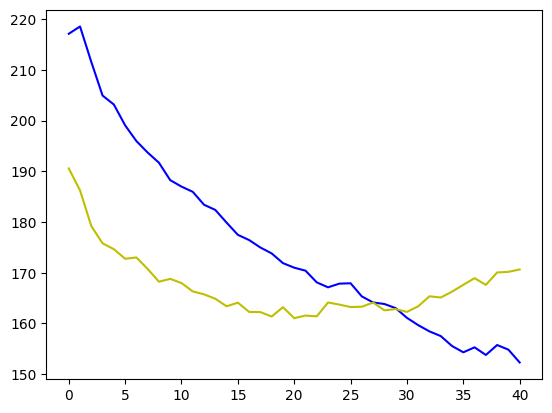

In [16]:
plt.plot(losses['nll_train_loss'],color='b')
plt.plot(losses['nll_val_loss'],color='y')




# CHECK LIKELIHOODS

In [10]:
automacaw_model.test_likelihood(train_loader)

149.44798559725865

In [10]:
# ukbb data
data_path =  project_path/'UKBB_data_extraction/ukbb_PRS_FreeSurfer_24265_nl2_np2_controls_SNPs_APOE_reorderPPMI_normalizedVols_normalized01ALL_HARMONIZED.csv'
ukb_dataset = PRSDataframe(data_path)

features = 172

batch_size = 64
m =len(ukb_dataset)
print(m)
#train_data, val_data = random_split(ukb_dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

ukbb_loader = DataLoader(ukb_dataset, batch_size=batch_size)

16861


In [12]:
automacaw_model.test_likelihood(ukbb_loader)

inf

# Save/Load Model

In [20]:
torch.save(automacaw_model,"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/PPMI_data/automacaw_model_age_sex_lrrk2_apoe4_freesurfer_v6_norm_harmonized_ukbb_vol_aparc_ct_vol.pt")

In [42]:
automacaw_model1 = torch.load("/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/PPMI_data/automacaw_model_age_sex_cohort_freesurferVols.pt")

## Counterfactuals

In [16]:
# ukbb_set = []

# # Iterate over the validation loader
# for x_obs in ukbb_loader:
#    ukbb_set.append(x_obs)

# # If you want to concatenate the batches into a single tensor
# ukbb_set = torch.cat(ukbb_set, dim=0)

# print(f'Validation set size: {ukbb_set.size()}')

Validation set size: torch.Size([16861, 176])


In [85]:
val_set = []

# Iterate over the validation loader
for x_obs in val_loader:
   val_set.append(x_obs)


val_set = torch.cat(val_set, dim=0)

print(f'Validation set size: {val_set.size()}')

Validation set size: torch.Size([98, 176])


In [86]:
var = 2

In [87]:
true_val = 1
cf_val = 0

In [88]:
#x_obs = ukbb_set # next(iter(val_loader))
x_obs = val_set
m = automacaw_model.feature_mean.detach().cpu().numpy()
s = automacaw_model.feature_std.detach().cpu().numpy()

filtered_rows_for_cf = x_obs[ (x_obs[:,var] == true_val )] # > 1 (x_obs[:, 1] == 1)] &
x_cf = automacaw_model.counterfactual(filtered_rows_for_cf, {var:cf_val}) # -2 # min age == 31 so have to subtract from cf
#x_cf = automacaw_model.counterfactual(x_obs, {1:0})
features = x_cf[:,4:] * s + m
x_obs = x_obs.detach().cpu().numpy()

In [16]:
print(x_obs[:,var])

#filtered_rows_for_cf

[0. 0. 0. ... 0. 0. 0.]


In [17]:
print(x_obs.shape)
print(features.shape)

(16861, 176)
(16852, 172)


In [114]:
# average analyses

In [89]:
filtered_rows = x_obs[x_obs[:, var] == true_val]#& (x_obs[:,1] == 1)] # > 1
print(filtered_rows)

[[53.          1.          1.         ...  0.52008372  0.57377664
   0.56039647]
 [73.          1.          1.         ...  0.50111336  0.47150057
   0.72365137]
 [59.          1.          1.         ...  0.49689772  0.43624796
   0.58901551]
 ...
 [66.          1.          1.         ...  0.51165245  0.37923449
   0.61299961]
 [59.          1.          1.         ...  0.47961362  0.47324144
   0.55467288]
 [64.          0.          1.         ...  0.56236106  0.44643017
   0.45100182]]


In [21]:
averages = np.mean(filtered_rows[:, 4:], axis=0) #-1

In [20]:
averages.shape


(172,)

In [21]:

print(x_cf[:,3])
print(x_obs[:,3])


[1. 0. 0. ... 1. 0. 0.]
[1. 0. 0. ... 1. 0. 0.]


<BarContainer object of 120 artists>

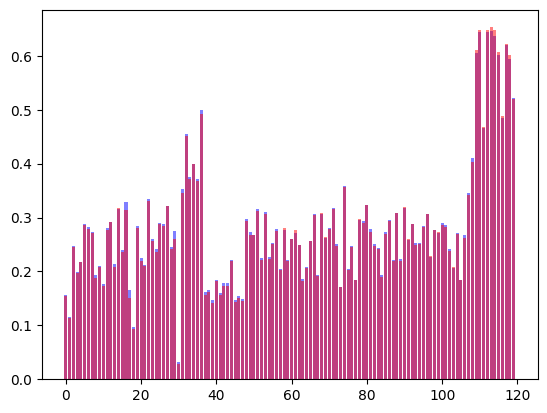

In [25]:
#x_obs are true vals and features are cfs
plt.bar(np.arange(172), averages[], color='b', alpha=0.5) # 139 # all xx people averaged
plt.bar(np.arange(172), (np.mean(features[:, 0:], axis=0)), color='r', alpha=0.5) #[:, 1:] # changed all xx people to yy
# so would expect sizes to increase when making healthy, right??

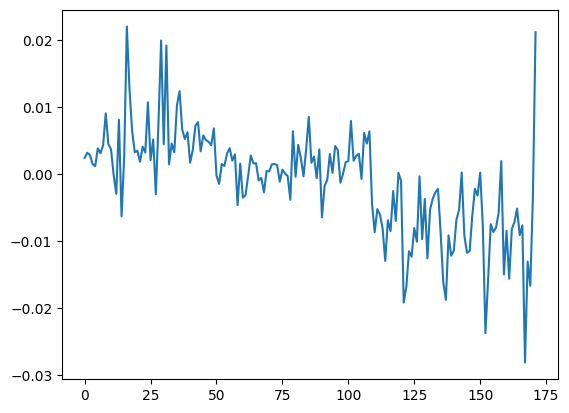

In [33]:
plt.plot((averages) - (np.mean(features[:, 0:], axis=0))) # [:, 1:] # averages should be smaller then features so should be negative values

In [34]:
diff = (averages) - (np.mean(features[:, 0:], axis=0)) # [:, 1:]
vals = np.argwhere(abs(diff) > 0)
#vals = np.argwhere(diff > 500)

In [35]:
dataset.df.columns

Index(['subjectkey', 'Image.Data.ID', 'Group', 'Sex', 'Sex_Numeric', 'Age',
       'Visit', 'Modality', 'Description', 'Type',
       ...
       'lh_precuneus_thickness', 'lh_rostralanteriorcingulate_thickness',
       'lh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness',
       'lh_superiorparietal_thickness', 'lh_superiortemporal_thickness',
       'lh_supramarginal_thickness', 'lh_transversetemporal_thickness',
       'lh_insula_thickness', 'eTIV'],
      dtype='object', length=222)

In [69]:
print(dataset.df.columns[125])


rh_superiortemporal_volume


In [93]:
for val in vals:
    print(val, diff[val])
    print(dataset.df.columns[val+50]) #4 UKBB, 25 PPMI

[0] [-0.0008253]
Index(['Left.Lateral.Ventricle'], dtype='object')
[1] [-0.00048453]
Index(['Left.Inf.Lat.Vent'], dtype='object')
[2] [0.00242521]
Index(['Left.Cerebellum.White.Matter'], dtype='object')
[3] [0.00275915]
Index(['Left.Cerebellum.Cortex'], dtype='object')
[4] [0.00430019]
Index(['Left.Thalamus.Proper'], dtype='object')
[5] [0.00706601]
Index(['Left.Caudate'], dtype='object')
[6] [0.00743099]
Index(['Left.Putamen'], dtype='object')
[7] [0.0069274]
Index(['Left.Pallidum'], dtype='object')
[8] [0.01785273]
Index(['X3rd.Ventricle'], dtype='object')
[9] [0.00634364]
Index(['X4th.Ventricle'], dtype='object')
[10] [0.00886164]
Index(['Brain.Stem'], dtype='object')
[11] [0.00669129]
Index(['Left.Hippocampus'], dtype='object')
[12] [0.00746827]
Index(['Left.Amygdala'], dtype='object')
[13] [0.01722345]
Index(['CSF'], dtype='object')
[14] [0.00092096]
Index(['Left.Accumbens.area'], dtype='object')
[15] [0.00874529]
Index(['Left.VentralDC'], dtype='object')
[16] [0.01294299]
Index([

In [103]:
# T-Tests

In [55]:
import pandas as pd
from scipy.stats import ttest_ind

In [23]:
column_names = dataset.df.columns[50:].values.tolist()
print(column_names)

['WM.hypointensities', 'Optic.Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent.x', 'BrainSegVolNotVentSurf', 'lhCortexVol', 'rhCortexVol', 'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'SubCortGrayVol', 'TotalGrayVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent', 'rh_caudalanteriorcingulate_volume', 'rh_caudalmiddlefrontal_volume', 'rh_cuneus_volume', 'rh_entorhinal_volume', 'rh_fusiform_volume', 'rh_inferiorparietal_volume', 'rh_inferiortemporal_volume', 'rh_isthmuscingulate_volume', 'rh_lateraloccipital_volume', 'rh_lateralorbitofrontal_volume', 'rh_lingual_volume', 'rh_medialorbitofrontal_volume', 'rh_middletemporal_volume', 'rh_parahippocampal_volume', 'rh_paracentral_volume', 'rh_parsopercularis_volume', 'rh_parsorbitalis_volume', 'rh_parstriangularis_volume', 'rh_pericalcarine_volume', 'rh_postcentral_volume', 'rh_posteriorcingulate_volume', 'rh_precentral_volume', 'rh_precuneus_volume', 

In [110]:
print(filtered_rows[:, 4:].shape)
print(features.shape)

(10362, 172)
(10362, 172)


In [111]:
true = pd.DataFrame(filtered_rows[:, 4:], columns=column_names)
cfs = pd.DataFrame(features[:,0:], columns=column_names)
print(cfs.shape)
print(true.shape)



(10362, 172)
(10362, 172)


In [197]:
# true.to_csv("/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/trueValues_APOE4_1_to_0_exp_flipped_aseg_ct_vol.csv", sep=',')
# cfs.to_csv("/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/cfValues_APOE4_1_to_0_exp_flipped_aseg_ct_vol.csv", sep=',')


In [62]:
# true.to_csv("/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/trueValues_LRRK2_1_0_freesurfer_v6_ukbbTestSet_vols_aseg_ct_vol.csv",sep=",")
# cfs.to_csv("/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/cfValues_LRRK2_1_0_freesurfer_v6_ukbbTestSet_vols_aseg_ct_vol.csv",sep=",")

In [112]:
# Construct the file paths dynamically using f-strings
true_file_path = f"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/trueValues_apoe_{true_val}_{cf_val}_freesurfer_v6_harmonized_ukbbTestSet_vols_aseg_ct_vol.csv"
cf_file_path = f"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/cfValues_apoe_{true_val}_{cf_val}_freesurfer_v6_harmonized_ukbbTestSet_vols_aseg_ct_vol.csv"

# Save the DataFrames to the new file paths
true.to_csv(true_file_path, sep=",")
cfs.to_csv(cf_file_path, sep=",")

In [98]:
columns_true = range(1, len(true.columns))
columns_cfs = range(1, len(cfs.columns))

In [99]:
print(columns_true)

range(1, 172)


In [100]:
# Perform t-tests for each column
t_test_results = {}
for col_true, col_cfs in zip(columns_true, columns_cfs):
    t_stat, p_value = ttest_ind(true.iloc[:, col_true], cfs.iloc[:, col_cfs])
    t_test_results[(col_true, col_cfs)] = {'t_statistic': t_stat, 'p_value': p_value}

In [101]:
# Print the results with column names for p-values < 0.05
for cols, result in t_test_results.items():
    col_name_true = true.columns[ cols[0]]
    col_name_cfs = cfs.columns[ cols[1]]
    if result['p_value'] < 0.05:
        print(f"T-test for columns '{col_name_true}' and '{col_name_cfs}': p-value = {result['p_value']}")


In [28]:
bernoulli_snps = [2]
categorical_snps = [3]# Define the scenarios for Bernoulli SNPs (only 0 and 1 are valid)
bernoulli_scenarios = [
    {"true": 0, "cf": 1},
    {"true": 1, "cf": 0}
]

# Define the scenarios for Categorical SNPs (0, 1, and 2 are valid)
categorical_scenarios = [
    {"true": 0, "cf": 1},
    {"true": 1, "cf": 0},
    {"true": 0, "cf": 2},
    {"true": 2, "cf": 2}
]

In [29]:
val_set = ukbb_set

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the SNPs
snps = list(range(2, 4))

# Define the scenarios for each SNP
# scenarios = [
#     {"true": 0, "cf": 1},
#     {"true": 1, "cf": 0},
#     {"true": 0, "cf": 2},
#     {"true": 2, "cf": 2},
#     {"true": 1, "cf": 2},
#     {"true": 2, "cf": 1}
# ]

# Function to run counterfactual analysis
def run_counterfactual_analysis(snp1, true1, cf1, snp2=None, true2=1, cf2=0):
    print(snp1)
    x_obs = val_set
    m = automacaw_model.feature_mean.detach().cpu().numpy()
    s = automacaw_model.feature_std.detach().cpu().numpy()

    if snp2 is None:
        # Handle single SNP case
        filtered_rows_for_cf = x_obs[x_obs[:, snp1] == true1]
        print(filtered_rows_for_cf.shape)
    else:
        # Handle complex SNP case
        filtered_rows_for_cf = x_obs[(x_obs[:, snp1] == true1) & (x_obs[:, snp2] == true2)]

    
    if filtered_rows_for_cf.shape[0] == 0:
        print(f"No true values found for SNP {snp1} with true value {true1}" +
              (f" and SNP {snp2} with true value {true2}" if snp2 is not None else ""))
        return

    try:
        # Attempt to compute the counterfactual
        x_cf = automacaw_model.counterfactual(filtered_rows_for_cf, {snp1: cf1, snp2: cf2})
        print("hee")
        
        # If successful, return the result
        # Transform features
        features = x_cf[:, 4:] * s + m
        x_obs_np = x_obs.detach().cpu().numpy()
    
        # Calculate averages
        filtered_rows = x_obs_np[x_obs_np[:, snp1] == true1]
        if snp2 is not None:
            filtered_rows = filtered_rows[filtered_rows[:, snp2] == true2]
    
        averages = np.mean(filtered_rows[:, 4:], axis=0)
        print("hi")
        # Plot and save the results
        plt.bar(np.arange(172), averages, color='b', alpha=0.5)
        plt.bar(np.arange(172), np.mean(features[:, 0:], axis=0), color='r', alpha=0.5)
        plot_filename = f"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/CF_plot_snp1_{snp1}_snp2_{snp2 if snp2 is not None else 'NA'}_true1_{true1}_cf1_{cf1}_true2_{true2 if snp2 is not None else 'NA'}_cf2_{cf2 if snp2 is not None else 'NA'}.svg"
        plt.savefig(plot_filename)
        plt.clf()  # Clear the figure for the next plot

        print("lee")
    
        column_names = dataset.df.columns[50:].values.tolist()
    
        true_df = pd.DataFrame(filtered_rows[:, 4:], columns=column_names)
        cf_df = pd.DataFrame(features[:, 0:], columns=column_names)
    
        true_file_path = f"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/trueValues_snp1_{snp1}_snp2_{snp2 if snp2 is not None else 'NA'}_true1_{true1}_cf1_{cf1}_true2_{true2 if snp2 is not None else 'NA'}_cf2_{cf2 if snp2 is not None else 'NA'}.csv"
        cf_file_path = f"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/lrrk2_apoe/cfValues_snp1_{snp1}_snp2_{snp2 if snp2 is not None else 'NA'}_true1_{true1}_cf1_{cf1}_true2_{true2 if snp2 is not None else 'NA'}_cf2_{cf2 if snp2 is not None else 'NA'}.csv"
    
        true_df.to_csv(true_file_path, sep=",")
        cf_df.to_csv(cf_file_path, sep=",")
        print("saved")
    
    except Exception as e:
        # Handle any exceptions by logging the error
        print("An error occurred during counterfactual computation.")
        print("Error details:", str(e))
        
        # Return None to indicate failure
        return None

    

# Run counterfactual analysis for each individual SNP with all scenarios
# for snp in snps:
#     if snp in bernoulli_snps:
#         for scenario in bernoulli_scenarios:
#             run_counterfactual_analysis(snp1=snp, true1=scenario["true"], cf1=scenario["cf"])
#     elif snp in categorical_snps:
#         for scenario in categorical_scenarios:
#             run_counterfactual_analysis(snp1=snp, true1=scenario["true"], cf1=scenario["cf"])
#     else:
#         print(f"SNP {snp} is not categorized as Bernoulli or Categorical")



In [46]:
scenario_c = [
    {"snp1": 2, "true1": 0, "cf1": 1, "snp2": 3, "true2": 0, "cf2": 1},
    {"snp1": 2, "true1": 1, "cf1": 0, "snp2": 3, "true2": 1, "cf2": 0},
    {"snp1": 2, "true1": 0, "cf1": 0, "snp2": 3, "true2": 0, "cf2": 1},
    {"snp1": 2, "true1": 0, "cf1": 0, "snp2": 3, "true2": 1, "cf2": 0},
    {"snp1": 2, "true1": 0, "cf1": 1, "snp2": 3, "true2": 0, "cf2": 0},
    {"snp1": 2, "true1": 1, "cf1": 0, "snp2": 3, "true2": 0, "cf2": 0},
    {"snp1": 2, "true1": 0, "cf1": 2, "snp2": 3, "true2": 0, "cf2": 0},
    {"snp1": 2, "true1": 2, "cf1": 0, "snp2": 3, "true2": 0, "cf2": 0},
    {"snp1": 2, "true1": 0, "cf1": 2, "snp2": 3, "true2": 0, "cf2": 1},
    {"snp1": 2, "true1": 2, "cf1": 0, "snp2": 3, "true2": 1, "cf2": 0},
    {"snp1": 2, "true1": 0, "cf1": 1, "snp2": 3, "true2": 0, "cf2": 1}
    

    # Add more scenarios as needed
    # {"snp1": ..., "true1": ..., "cf1": ..., "snp2": ..., "true2": ..., "cf2": ...}
]

In [47]:
# Run counterfactual analysis for each scenario
for scenario in scenario_c:
    run_counterfactual_analysis(snp1=scenario["snp1"], true1=scenario["true1"], cf1=scenario["cf1"],
                                snp2=scenario["snp2"], true2=scenario["true2"], cf2=scenario["cf2"])


2
hee
hi
lee
saved
2
hee
hi
lee
saved
2
hee
hi
lee
saved
2
hee
hi


/home/gdagasso/anaconda3/envs/prs_torch/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


lee
saved
2
hee
hi
lee
saved
2
hee
hi
lee
saved
2
An error occurred during counterfactual computation.
Error details: Expected value argument (Tensor of shape (10357, 1)) to be within the support (Boolean()) of the distribution Bernoulli(probs: tensor([0.1100]), logits: tensor([-2.0907])), but found invalid values:
tensor([[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]])
2
No true values found for SNP 2 with true value 2 and SNP 3 with true value 0
2
An error occurred during counterfactual computation.
Error details: Expected value argument (Tensor of shape (10357, 1)) to be within the support (Boolean()) of the distribution Bernoulli(probs: tensor([0.1100]), logits: tensor([-2.0907])), but found invalid values:
tensor([[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]])
2
No true values found for SNP 2 with true value 2 and SNP 3 with true value 1
2
hee
hi
lee
saved


<Figure size 640x480 with 0 Axes>

In [91]:
import pandas as pd

# Assuming val_indices and val_data have been defined previously and val_set is equivalent to x_obs
val_indices = val_data.indices 
val_indices_list = list(val_indices)

# Convert the validation set (x_obs) to a DataFrame if it's not already one, using indices for alignment
val_set_df = pd.DataFrame(val_set, index=val_indices_list)

# Filter the validation set based on your conditions (e.g., column 12 equals 0)
filtered_rows_for_cf = val_set_df[val_set_df.iloc[:, 2] == 1]

# Get the indices of the filtered rows
filtered_indices = filtered_rows_for_cf.index

# Map these indices back to the original dataframe to get the subset
matched_val_df = dataset.df.iloc[val_indices_list]

# Extract the group information for the filtered subset
filtered_subset_with_group_info = matched_val_df.loc[filtered_indices, 'Group']

# Display the shape and the content of the filtered subset with group info
print(filtered_subset_with_group_info.shape)
print(filtered_subset_with_group_info.head())  # Show the first few rows

# If you want to convert it to a list
group_info_list = filtered_subset_with_group_info.tolist()
print(group_info_list)


(20,)
320    Prodromal
466    Prodromal
461           PD
353    Prodromal
314           PD
Name: Group, dtype: object
['Prodromal', 'Prodromal', 'PD', 'Prodromal', 'PD', 'Prodromal', 'Prodromal', 'PD', 'PD', 'PD', 'PD', 'Prodromal', 'Prodromal', 'Prodromal', 'Prodromal', 'PD', 'Prodromal', 'Prodromal', 'Prodromal', 'Prodromal']


In [76]:
filtered_rows_for_cf

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
81,53.0,0.0,0.0,0.0,0.159579,0.081540,0.385791,0.208682,0.260968,0.288558,...,-0.076359,0.293793,-0.105712,0.011547,0.174989,-0.013139,-0.023643,-0.028249,-0.121964,0.689594
44,57.0,1.0,0.0,0.0,0.071348,0.094386,0.258031,0.181766,0.262724,0.327480,...,0.600290,0.496633,0.541659,0.559946,0.613200,0.575313,0.584638,0.389821,0.389680,0.648922
140,70.0,1.0,0.0,1.0,0.266297,0.179185,0.357097,0.199180,0.266786,0.243521,...,0.551890,0.335802,0.514518,0.637422,0.547294,0.525363,0.540859,0.571093,0.609029,0.716195
95,77.0,0.0,0.0,0.0,0.146758,0.128094,0.199345,0.139533,0.186324,0.203388,...,0.558281,0.599240,0.665974,0.664895,0.562873,0.539760,0.621797,0.535381,0.512148,0.408274
312,69.0,1.0,0.0,0.0,0.466571,0.460955,0.227350,0.268869,0.316291,0.336478,...,0.652497,0.310982,0.574668,0.561680,0.746385,0.533401,0.617176,0.577838,0.460185,0.781310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,55.0,1.0,0.0,0.0,0.158379,0.145375,0.268677,0.193572,0.245194,0.270695,...,0.565486,0.458907,0.548994,0.499236,0.642034,0.534549,0.656222,0.441251,0.424932,0.609676
201,53.0,0.0,0.0,0.0,0.056014,0.058216,0.232436,0.180253,0.217895,0.290385,...,0.549036,0.604865,0.492124,0.592044,0.567679,0.539186,0.626530,0.491538,0.513018,0.515932
192,53.0,1.0,0.0,0.0,0.076126,0.120712,0.307565,0.254557,0.322874,0.321110,...,0.600290,0.640587,0.488844,0.675582,0.634482,0.533975,0.695268,0.416801,0.450175,0.607184
278,77.0,0.0,0.0,0.0,0.262401,0.078734,0.232695,0.226769,0.303986,0.355735,...,0.465287,0.565154,0.426839,0.522661,0.540218,0.538038,0.614698,0.388255,0.428586,0.627277


In [93]:
filtered_rows_for_cf = x_obs[x_obs[:, var] == true_val]#& (x_obs[:,1] == 1)] # > 1


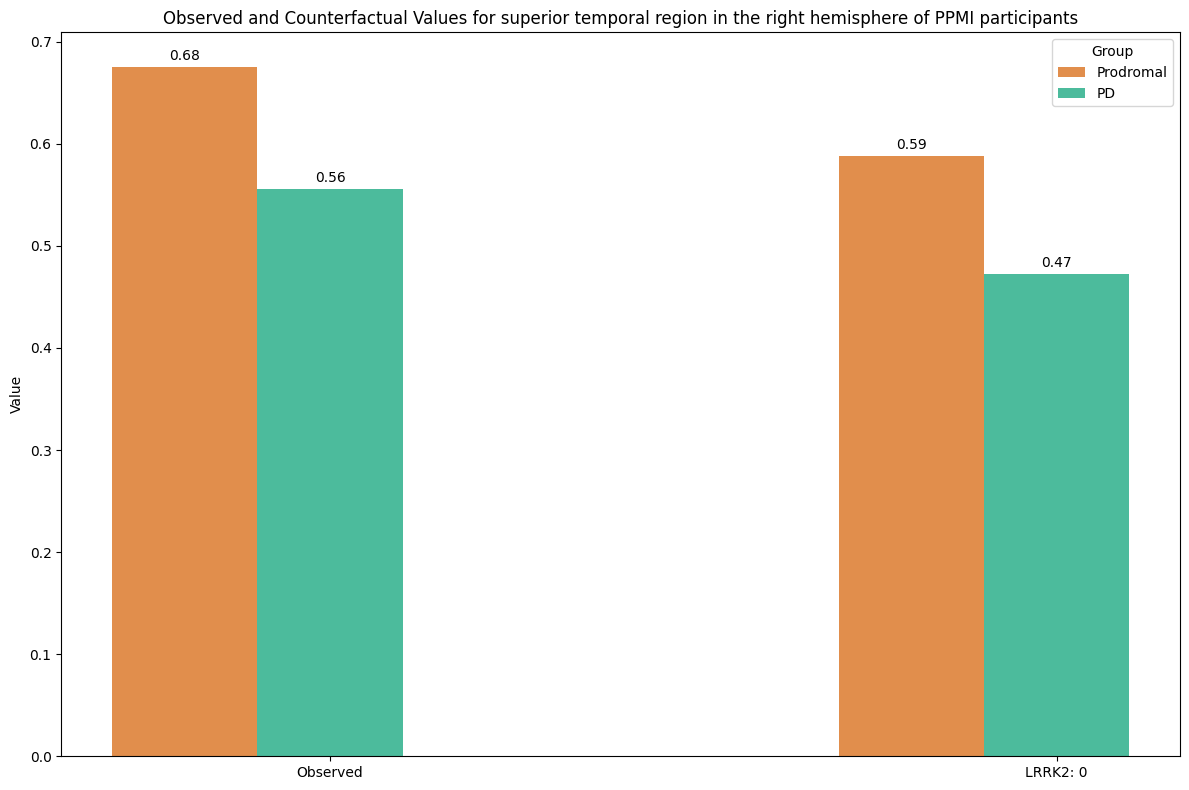

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# List of participant indices to plot
participants = [0,7] #[0, 2, 1]  # Change these to the participants you are interested in

# Corresponding custom labels for the legend
custom_labels = ['Prodromal', 'PD']#['Control', 'Prodromal', 'PD']  # Custom labels for the participants

# Feature index 219 (considering Python's 0-based index, it's the 220th feature)
feature_index = 124

# Define labels for the bars
labels = ['Observed', 'LRRK2: 0']

# Define colorblind-friendly colors for each participant's bars
participant_colors = ['#D55E00', '#009E73'] #['#0072B2', '#D55E00', '#009E73']  # Blue, Orange, Green

# Create the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Width of each bar
bar_width = 0.2

# Positions of the bars on the x-axis
r = np.arange(len(labels))

# Loop through each participant to plot their values
for i, participant in enumerate(participants):
    # Extract values for feature 219 for the specific participant
    x_obs = filtered_rows_for_cf[participant, feature_index]  # Observed value
    cf_0_1 = features[participant, -1]                        # Counterfactual 0_1
    
    # Values for the bar plot
    values = [x_obs, cf_0_1]

    # Calculate bar positions
    bar_positions = [pos + bar_width * i for pos in r]

    # Use a single color for each participant's bars
    color = participant_colors[i]
    
    # Plot the bars
    bars = ax.bar(bar_positions, values, width=bar_width, color=color, alpha=0.7, label=custom_labels[i])

    # Add values on top of each bar for clarity
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Labels and title
ax.set_ylabel('Value')
ax.set_title('Observed and Counterfactual Values for superior temporal region in the right hemisphere of PPMI participants')

# Add x-axis labels for each group of bars
ax.set_xticks([r + bar_width for r in range(len(labels))])
ax.set_xticklabels(labels)

# Add a legend with custom labels
ax.legend(title='Group')

# Display the plot
plt.tight_layout()

# Save the plot
plot_filename = f"/media/gdagasso/TOSHIBA EXT/prs-pd-counterfactual/CF_dataframes/ukbb_testset/CF_plot_multi_participants_suptemp_LRRK2_ppmiPPL_prod_pd_only_true1.svg"
plt.savefig(plot_filename)
plt.show()



## MANOVA

In [151]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [152]:
true['Group'] = 'Original'
cfs['Group'] = 'Counterfactual'
combined_df = pd.concat([true, cfs], ignore_index=True)

In [153]:
X = combined_df.drop(columns=['Group'])

In [154]:
X.head()
X.shape

(108, 188)

In [155]:
group_labels = np.where(combined_df['Group'] == 'Original', 0, 1)


In [156]:
manova_model = sm.multivariate.MANOVA(X, group_labels)
manova_results = manova_model.mv_test()

print(manova_results.summary())

                       Multivariate linear model
                                                                       
-----------------------------------------------------------------------
           x0                Value        Num DF  Den DF F Value Pr > F
-----------------------------------------------------------------------
          Wilks' lambda          -0.0000 108.0000 0.0000 -0.0000    nan
         Pillai's trace          31.2538 108.0000 0.0000 -0.0000    nan
 Hotelling-Lawley trace 54652018981.9447 108.0000 0.0000  0.0000    nan
    Roy's greatest root 54652019019.3325 108.0000 0.0000  0.0000    nan



## MANCOVA

In [195]:
true = pd.DataFrame(filtered_rows[:, 4:], columns=column_names)
cfs = pd.DataFrame(features[:,0:], columns=column_names)
true['Group'] = 'Original'
cfs['Group'] = 'Counterfactual'

covs = pd.DataFrame(filtered_rows[:,0:2])

covs.columns = ['Age','Sex']

true_covs = pd.concat([true, covs], axis=1)
print(true_covs.head)
cfs_covs = pd.concat([cfs, covs], axis=1)
print(cfs_covs.head)

combined_df = pd.concat([true_covs, cfs_covs], ignore_index=True)

print(cfs.shape)
print(true.shape)

#combined_df = pd.concat([combined_df, covs], axis=1)


<bound method NDFrame.head of     Left.Lateral.Ventricle  Left.Inf.Lat.Vent  Left.Cerebellum.White.Matter  \
0                12.117653           0.338188                      5.187564   
1                 7.094946           0.052498                     10.384967   
2                 8.329602           0.064341                      9.842771   
3                10.679191           0.033871                     10.469242   
4                 9.759960           0.104718                      7.934385   
5                 7.697027           0.055678                      6.939088   
6                 5.405158           0.028279                      6.017479   
7                 2.322407           0.042757                      8.948773   
8                 3.605886           0.006174                      6.043318   
9                 8.737318           0.064513                      5.497760   
10                1.434351           0.026463                      5.262030   
11                8.05

In [196]:
X = combined_df.drop(columns=['Group'])

In [197]:
group_labels = np.where(combined_df['Group'] == 'Original', 0, 1)

# Perform MANCOVA
mancova_model = sm.multivariate.MANOVA.from_formula('X ~ Age + Sex + Group', data=combined_df)
mancova_results = mancova_model.mv_test()


In [198]:
print(mancova_results.summary())

                         Multivariate linear model
                                                                           
---------------------------------------------------------------------------
        Intercept               Value          Num DF Den DF F Value Pr > F
---------------------------------------------------------------------------
           Wilks' lambda              -0.0000 99.0000 0.0000 -0.0000    nan
          Pillai's trace               1.7428 99.0000 0.0000 -0.0000    nan
  Hotelling-Lawley trace -32399997319212.4688 99.0000 0.0000 -0.0000    nan
     Roy's greatest root               0.0750 99.0000 0.0000  0.0000    nan
---------------------------------------------------------------------------
                                                                           
----------------------------------------------------------------------------
           Group                Value        Num DF  Den DF  F Value  Pr > F
-----------------------------------

## PAIRED ANOVA

In [70]:
from scipy.stats import f_oneway

# Assuming you have two DataFrames: original_df and counterfactual_df
# Each DataFrame contains the same participants with original and counterfactual values for the same features.
significant_features = []

# Iterate over each feature
for feature in true.columns:
    # Extract original and counterfactual values for the current feature
    original_values = true[feature]
    counterfactual_values = cfs[feature]
    
    # Perform paired ANOVA for the current feature
    f_statistic, p_value = f_oneway(original_values, counterfactual_values)
    if p_value < 0.05:
        significant_features.append(feature)
    
    # Print the results
    print(f"Paired ANOVA results for feature '{feature}':")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}\n")

if significant_features:
    print("Significant features with p-value < 0.05:")
    for feature in significant_features:
        print(feature)
else:
    print("No significant features with p-value < 0.05 found.")

Paired ANOVA results for feature 'Left.Lateral.Ventricle':
F-statistic: 2.4445840606351485e-05
P-value: 0.9960649066066404

Paired ANOVA results for feature 'Left.Inf.Lat.Vent':
F-statistic: 0.0005020275890366761
P-value: 0.9821687645101842

Paired ANOVA results for feature 'Left.Cerebellum.White.Matter':
F-statistic: 0.0011685313973105232
P-value: 0.9727987340612851

Paired ANOVA results for feature 'Left.Cerebellum.Cortex':
F-statistic: 1.2865044537291708e-05
P-value: 0.9971453093673784

Paired ANOVA results for feature 'Left.Thalamus':
F-statistic: 0.00012310992488699974
P-value: 0.9911693661747322

Paired ANOVA results for feature 'Left.Caudate':
F-statistic: 0.00045124058359647724
P-value: 0.9830946007420295

Paired ANOVA results for feature 'Left.Putamen':
F-statistic: 9.503574028084724e-05
P-value: 0.9922412657509617

Paired ANOVA results for feature 'Left.Pallidum':
F-statistic: 2.7093969723795336e-05
P-value: 0.9958572504077855

Paired ANOVA results for feature 'X3rd.Ventricle

# Single person analyses

In [25]:
print(x_obs[:,0])
print(x_obs[:,1])
print(x_obs[:,2])
print(x_obs[:,3])

[64. 56. 72. 75. 72. 56. 62. 65. 61. 75. 64. 67. 66. 57. 52. 71. 39. 59.
 62. 80. 74. 57. 65. 57. 64. 70. 64. 70. 49. 77. 70. 76. 72. 68. 53. 77.
 53. 53. 67. 61. 58. 72. 63. 34. 56. 68. 70. 56. 66. 50. 67. 53. 75. 71.
 49. 58. 81. 62. 65. 52. 55. 61. 67. 79.]
[1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]


In [48]:
print(filtered_rows_for_cf[:,0])
print(filtered_rows_for_cf[:,1])
print(filtered_rows_for_cf[:,2])
print(filtered_rows_for_cf[:,3])

tensor([64., 56., 72., 75., 72., 56., 62., 65., 61., 75., 64., 66., 71., 59.,
        80., 57., 65., 57., 70., 64., 70., 49., 77., 70., 76., 72., 68., 53.,
        77., 53., 53., 67., 61., 58., 72., 63., 34., 56., 68., 56., 66., 50.,
        67., 53., 75., 71., 49., 58., 81., 62., 65., 55., 61., 67.],
       dtype=torch.float64)
tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.],
       dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=torch.float64)
tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.

In [52]:
partipant = 3

print(filtered_rows_for_cf[partipant,2])
print(x_cf[partipant,2])
#print(x_obs.shape)
#features.shape

tensor(0., dtype=torch.float64)
1.0


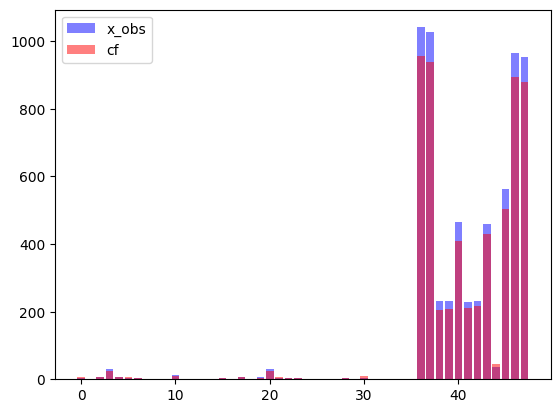

In [53]:
#x_obs are true vals and features are cfs
plt.bar(np.arange(48), x_obs[partipant,4:-1], color='b', alpha=0.5,label='x_obs')
plt.bar(np.arange(48), features[0,0:-1], color='r', alpha=0.5,label='cf') #features[:, 0:-1]
plt.legend()

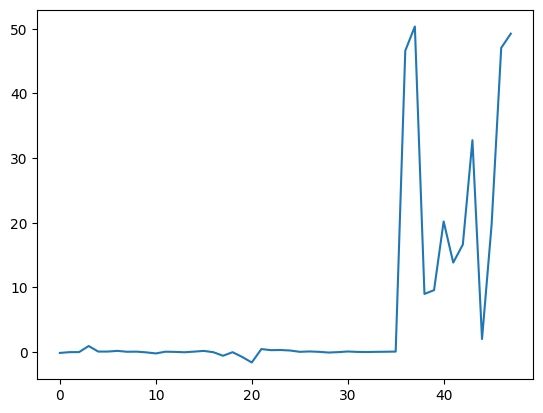

In [54]:
plt.plot(x_obs[partipant,4:-1] -features[partipant,0:-1])

In [55]:
np.argmax(x_obs[partipant,3:] -features[partipant,:])

ValueError: operands could not be broadcast together with shapes (50,) (49,) 

In [56]:
dataset.df.columns[126]

'Left.Lateral.Ventricle'

In [57]:
diff = x_obs[partipant,4:-1] -features[partipant,0:-1] # [:, 1:]
vals = np.argwhere(abs(diff) > 5)
#vals = np.argwhere(diff > 0)

In [58]:
for val in vals:
    print(val, diff[val])
    print(dataset.df.columns[val+126]) #4 UKBB, 25 PPMI

[36] [46.58767017]
Index(['BrainSegVol'], dtype='object')
[37] [50.34342416]
Index(['BrainSegVolNotVent'], dtype='object')
[38] [8.99701585]
Index(['lhCortexVol'], dtype='object')
[39] [9.5852163]
Index(['rhCortexVol'], dtype='object')
[40] [20.2046974]
Index(['CortexVol'], dtype='object')
[41] [13.84734487]
Index(['lhCerebralWhiteMatterVol'], dtype='object')
[42] [16.63159738]
Index(['rhCerebralWhiteMatterVol'], dtype='object')
[43] [32.76794708]
Index(['CerebralWhiteMatterVol'], dtype='object')
[45] [19.72427591]
Index(['TotalGrayVol'], dtype='object')
[46] [47.03150346]
Index(['SupraTentorialVol'], dtype='object')
[47] [49.2351229]
Index(['SupraTentorialVolNotVent'], dtype='object')
